In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 10:35:05 2022

@author: bas
"""
from __future__ import print_function, division

import os
import numpy as np
import math

from matplotlib import rcParams
import matplotlib.pyplot as plt

import xpsi
from xpsi.global_imports import gravradius


import sys
sys.path.append('../')
from custom_tools import CustomInstrument, CustomHotRegion, CustomHotRegion_Accreting, CustomPhotosphere_4D, CustomPhotosphere_5D, CustomPhotosphere_Bobrikova, CustomSignal, CustomPrior, CustomPrior_NoSecondary, plot_2D_pulse


np.random.seed(xpsi._rank+10)
print('Rank reporting: %d' % xpsi._rank)

################################ OPTIONS ###############################
accreting = True
second = False



##################################### DATA ####################################
settings = dict(counts = np.loadtxt('../model_data/example_synthetic_realisation.dat', dtype=np.double),
        channels=np.arange(20,201), #201
        phases=np.linspace(0.0, 1.0, 33),
        first=0, last=180,
        exposure_time=984307.6661)
data = xpsi.Data(**settings)

################################## INSTRUMENT #################################
try:
    NICER = CustomInstrument.from_response_files(ARF = '../model_data/nicer_v1.01_arf.txt',
                                             RMF = '../model_data/nicer_v1.01_rmf_matrix.txt',
                                             max_input = 500, #500
                                             min_input = 0,
                                             channel_edges = '../model_data/nicer_v1.01_rmf_energymap.txt')
except:
    print("ERROR: You might miss one of the following files (check Modeling tutorial or the link below how to find them): \n model_data/nicer_v1.01_arf.tx, model_data/nicer_v1.01_rmf_matrix.txt, model_data/nicer_v1.01_rmf_energymap.txt")
    print("https://github.com/ThomasEdwardRiley/xpsi_workshop.git")
    exit()


################################## SPACETIME ##################################

# spacetime = xpsi.Spacetime.fixed_spin(300.0)


bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))      # (Earth) inclination to rotation axis

frequency = 401.0
spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=frequency))


################################## HOTREGIONS #################################
################################## PRIMARY ####################################
from xpsi import HotRegions
print("hotregions")
# bounds = dict(super_colatitude = (None, None),
#               super_radius = (None, None),
#               phase_shift = (0.0, 0.1),
#               super_temperature = (5.1, 6.8),
#               super_modulator = (-0.3, 0.3))

bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1),
              super_tbb = (0.00015, 0.003),
              super_te = (40., 200.),
              super_tau = (0.5, 3.5))

if accreting:
    primary = CustomHotRegion_Accreting(bounds=bounds,
       	                    values={},
       	                    symmetry=False, #call general integrator instead of for azimuthal invariance
       	                    omit=False,
       	                    cede=False,
       	                    concentric=False,
       	                    sqrt_num_cells=32,
       	                    min_sqrt_num_cells=10,
       	                    max_sqrt_num_cells=64,
       	                    num_leaves=100,
       	                    num_rays=200,
       	                    prefix='p')
elif not accreting:
    primary = CustomHotRegion(bounds=bounds,
       	                    values={},
       	                    symmetry=False, #call general integrator instead of for azimuthal invariance
       	                    omit=False,
       	                    cede=False,
       	                    concentric=False,
       	                    sqrt_num_cells=32,
       	                    min_sqrt_num_cells=10,
       	                    max_sqrt_num_cells=64,
       	                    num_leaves=100,
       	                    num_rays=200,
                            modulated = True, #modulation flag
       	                    prefix='p')



###################################### SECONDARY ##############################
if second:
    # If you derive bounds for a secondary hotspots, you cannot also define bounds
    # (above). You must set them to "None" to avoid some conflict. 
    
    # bounds['super_temperature'] = None # declare fixed/derived variable
    # bounds['super_modulator'] = None
    bounds['super_tbb'] = None
    bounds['super_te'] = None
    bounds['super_tau'] = None
    
    
    #print("printing primary parameters")
    #print(primary.params)
    
    
    class derive(xpsi.Derive):
        def __init__(self):
            """
            We can pass a reference to the primary here instead
            and store it as an attribute if there is risk of
            the global variable changing.
    
            This callable can for this simple case also be
            achieved merely with a function instead of a magic
            method associated with a class.
            """
            pass
    
        def __call__(self, boundto, caller = None):
            # one way to get the required reference
            global primary # unnecessary, but for clarity
            return primary['super_temperature'] - 0.2
        
    class derive_modulator(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            return primary['super_modulator']  
    
    class derive_tbb(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            # print("super_tbb derive")
            # print(primary['super_tbb'])
            return primary['super_tbb']  
        
    class derive_te(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            return primary['super_te']  
    
    class derive_tau(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            return primary['super_tau']  
        
    if accreting:
        secondary = CustomHotRegion_Accreting(bounds=bounds, # can otherwise use same bounds
        	                      values={'super_tbb': derive_tbb(), 'super_te': derive_te(), 'super_tau': derive_tau()},
        	                      symmetry=False, #call general integrator instead of for azimuthal invariance
        	                      omit=False,
        	                      cede=False, 
        	                      concentric=False,
        	                      sqrt_num_cells=32,
        	                      min_sqrt_num_cells=10,
        	                      max_sqrt_num_cells=100,
        	                      num_leaves=100,
        	                      num_rays=200,
        	                      do_fast=False,
        	                      is_antiphased=True,
        	                      prefix='s')
    elif not accreting:
        secondary = CustomHotRegion(bounds=bounds, # can otherwise use same bounds
         	                      values={'super_temperature': derive(), 'super_modulator': derive_modulator()},
         	                      symmetry=False, #call general integrator instead of for azimuthal invariance
         	                      omit=False,
         	                      cede=False, 
         	                      concentric=False,
         	                      sqrt_num_cells=32,
         	                      min_sqrt_num_cells=10,
         	                      max_sqrt_num_cells=100,
         	                      num_leaves=100,
         	                      num_rays=200,
         	                      do_fast=False,
         	                      is_antiphased=True,
                                  modulated=True,
         	                      prefix='s')
    
    
    
    
    hot = HotRegions((primary, secondary))
    # h = hot.objects[0]
    # hot['p__super_temperature'] = 6.0 # equivalent to ``primary['super_temperature'] = 6.0``
    # print("printing hot:",hot)
elif not second:
    hot = HotRegions((primary,))
    
    
    
################################ ATMOSPHERE ################################### 
      
try:
    os.environ.get('n_params')
    n_params = os.environ['n_params']
except:
    if accreting == True:
        n_params = "B"
    elif accreting == False:
        n_params = "5"


print("n_params: ",n_params)

if n_params == "4":   
    photosphere = CustomPhotosphere_4D(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019.npz'

elif n_params== "5":
    photosphere = CustomPhotosphere_5D(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    # photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019_5D_no_effect.npz'
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019_modulated_0dot5_to_2.npz'
    # photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/Bobrikova_compton_slab.npz'

elif n_params== "B":
    photosphere = CustomPhotosphere_Bobrikova(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'

else:
    print("no dimensionality provided!")

################################### STAR ######################################

star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
# star['mass'] = 1.6
# star['radius'] = 14.0
# star['distance'] = 0.2
# star['cos_inclination'] = math.cos(1.25)
# star['p__phase_shift'] = 0.0
# star['p__super_colatitude'] = 1.0
# star['p__super_radius'] = 0.075
# star['p__super_temperature'] = 6.2 
# star['p__super_modulator'] = 0.0

# star['s__phase_shift'] = 0.025 #0.2 gives problems!
# star['s__super_colatitude'] = math.pi - 1.0
# star['s__super_radius'] = 0.025


# with modulator
tbb=0.003
te=200.
tau=0.5
#modulator = -0.1

if second:
    p = [1.6, #1.4, #grav mass
          14.0,#12.5, #coordinate equatorial radius
          0.2, # earth distance kpc
          math.cos(1.25), #cosine of earth inclination
          0.0, #phase of hotregion
          1.0, #colatitude of centre of superseding region
          0.075,  #angular radius superceding region
          tbb,
          te,
          tau,
          #6.2, #primary temperature
          #modulator, #modulator
          0.025,
          math.pi - 1.0,
          0.075
          ]
elif not second:
    p = [1.6, #1.4, #grav mass
          14.0,#12.5, #coordinate equatorial radius
          0.2, # earth distance kpc
          math.cos(1.25), #cosine of earth inclination
          0.0, #phase of hotregion
          1.0, #colatitude of centre of superseding region
          0.075,  #angular radius superceding region
          tbb,
          te,
          tau,
          #6.2, #primary temperature
          #modulator, #modulator
          ]
     
# without modulator
# p = [1.6, #1.4, #grav mass
#       14.0,#12.5, #coordinate equatorial radius
#       0.2, # earth distance kpc
#       math.cos(1.25), #cosine of earth inclination
#       0.0, #phase of hotregoin
#       1.0, #colatitude of centre of superseding region
#       0.075,  #angular radius superceding region
#       6.2, #primary temperature
#       0.025,
#       math.pi - 1.0,
#       0.025
#       ]

star(p)
star.update() 

print("printing Parameters of the star:")
print(star.params)



/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|               Version: 0.7.10               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0
Rank reporting: 0
Setting channels for event data...
Channels set.
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.0

In [10]:
import pickle

path = '/home/bas/Documents/Projects/x-psi/Bobrikova_crosscomparison_pulses/'

with open(path+'/pulse.pkl','rb') as tf:
    phi1, pytI = pickle.load(tf)

flux_2kev_bobr = pytI[:,90]
flux_5kev_bobr = pytI[:,118]
flux_8kev_bobr = pytI[:,133]

fluxes_bobr = (flux_2kev_bobr, flux_5kev_bobr, flux_8kev_bobr)

In [11]:
energies=np.logspace(-1.0,np.log10(8.0), 128, base=10.0)
photosphere.integrate(energies, threads=4)

flux_2kev_xpsi = photosphere.signal[0][0][87] # 2.012 KeV
flux_5kev_xpsi = photosphere.signal[0][0][113] # 4.935 KeV
flux_8kev_xpsi = photosphere.signal[0][0][-1] # 8 KeV

fluxes_xpsi = (flux_2kev_xpsi, flux_5kev_xpsi, flux_8kev_xpsi)

Text(0.5,0,'spin=401.0 [Hz] te=1.02e+02 [keV], tbb=1.53e+00 [keV], tau=5.00e-01 [-]')

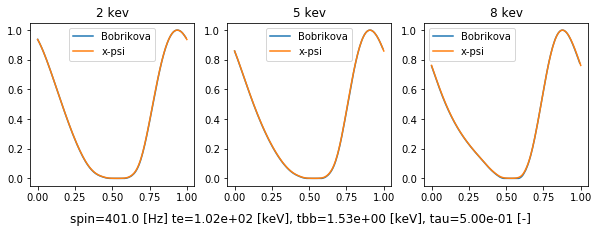

In [12]:
titles = ('2 kev', '5 kev', '8 kev')

fig, axes = plt.subplots(1,3,figsize=(10,3))

for ax, flux_bobr, flux_xpsi, title in zip(axes, fluxes_bobr, fluxes_xpsi, titles):
    ax.plot(phi1, flux_bobr/max(flux_bobr), label='Bobrikova')
    ax.plot(hot.phases_in_cycles[0], flux_xpsi/max(flux_xpsi), label='x-psi')
    ax.set_title(title)
    ax.legend()
    
fig.suptitle('spin={} [Hz] te={:.2e} [keV], tbb={:.2e} [keV], tau={:.2e} [-]'.format(frequency, te*0.511, tbb*511, tau),y=0)

star["p__super_tbb"]=0.003
star.update()
photosphere.integrate(energies, threads=8)

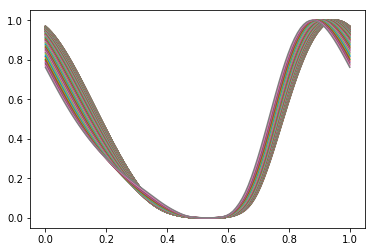

In [7]:
for k in range(len(energies)):
    plt.plot(hot.phases_in_cycles[0],photosphere.signal[0][0][k]/max(photosphere.signal[0][0][k]))

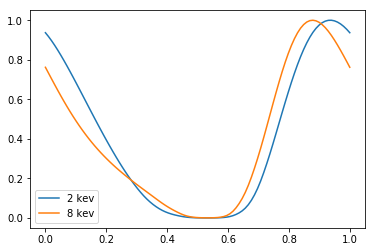

In [8]:
plt.plot(hot.phases_in_cycles[0],photosphere.signal[0][0][87]/max(photosphere.signal[0][0][87]),label='2 kev')
plt.plot(hot.phases_in_cycles[0],photosphere.signal[0][0][-1]/max(photosphere.signal[0][0][-1]), label='8 kev')
plt.legend()